In [1]:
!pip install torchinfo

In [2]:
# 라이브러리 로드
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from PIL import Image
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from glob import glob

from typing import Tuple, Sequence, Callable
import csv

from torchvision import transforms
from torchvision.models import resnet50

from sklearn.model_selection import StratifiedKFold


In [6]:
%cd '/content/drive/MyDrive/Colab Notebooks/dacon_vision'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(10)

torch.manual_seed(10)

torch.cuda.manual_seed_all(10)

/content/drive/MyDrive/Colab Notebooks/dacon_vision


## 데이터 로더

In [14]:
class DirtyMnist(Dataset):
  def __init__(self, index, mode, label, transforms = None):
    self.mode = mode
    self.transforms = transforms

    assert self.mode in ['train', 'test']

    self.index = index
    self.label = label

    assert len(index) == len(label)

  def __len__(self):
    return len(self.index)

  def __getitem__(self, idx):
    image_id = self.index[idx]
    image = Image.open(os.path.join(self.mode, f'{str(image_id).zfill(5)}.png'))

    image = image.convert("RGB")

    target = self.label[idx]

    if self.transforms is not None:
      image = self.transforms(image)

    return image, target

## Image Augmentation

In [15]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [16]:
answer = pd.read_csv("dirty_mnist_2nd_answer.csv")

answer_index = answer['index'].values
label = answer.iloc[:, 1:].values

In [17]:
train_set = DirtyMnist(answer_index, 'train', label, transforms_train)

In [18]:
train_loader = DataLoader(train_set, batch_size=64, 
                          shuffle = True,num_workers=4, pin_memory=True)

In [ ]:
image, target = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


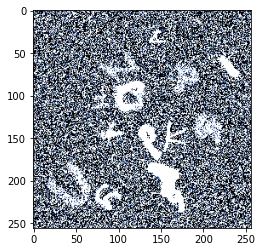

In [ ]:
plt.imshow(image[0].numpy().transpose(1, 2, 0))

# Model

In [19]:
class Resnet_Model(torch.nn.Module):
  def __init__(self):
    super(Resnet_Model, self).__init__()
    self.resnet = resnet50(pretrained=True)
    self.classifier = nn.Linear(1000, 26)

  def forward(self, x):
    out = self.resnet(x)
    out = self.classifier(out)

    return out

model = Resnet_Model().to(device)
print(summary(model, input_size=(1, 3, 256, 256), verbose=0))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [1, 1000]                 --
|    └─Conv2d: 2-1                       [1, 64, 128, 128]         9,408
|    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
|    └─ReLU: 2-3                         [1, 64, 128, 128]         --
|    └─MaxPool2d: 2-4                    [1, 64, 64, 64]           --
|    └─Sequential: 2-5                   [1, 256, 64, 64]          --
|    |    └─Bottleneck: 3-1              [1, 256, 64, 64]          75,008
|    |    └─Bottleneck: 3-2              [1, 256, 64, 64]          70,400
|    |    └─Bottleneck: 3-3              [1, 256, 64, 64]          70,400
|    └─Sequential: 2-6                   [1, 512, 32, 32]          --
|    |    └─Bottleneck: 3-4              [1, 512, 32, 32]          379,392
|    |    └─Bottleneck: 3-5              [1, 512, 32, 32]          280,064
|    |    └─Bottleneck: 3-6              [1, 512, 32, 32] 

In [20]:
pwd

'/content/drive/My Drive/Colab Notebooks/dacon_vision'

In [21]:
# 모델 저장
def save_checkpoint(epoch, model, optimizer):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer}
    filename = 'Multi_MNIST.pth.tar'
    torch.save(state, filename)

In [23]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MultiLabelSoftMarginLoss()

num_epochs = 50
model.train()

for epoch in range(num_epochs):
  for i, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            outputs = outputs > 0.5
            acc = (outputs == targets).float().mean()
            print(f'{epoch}: {loss.item():.5f}, {acc.item():.5f}')

  save_checkpoint(epoch, model, optimizer)

0: 0.72376, 0.54087
0: 0.71006, 0.54447
0: 0.69824, 0.52644
0: 0.69765, 0.53305
0: 0.69741, 0.53966
0: 0.69538, 0.53245
0: 0.69803, 0.53666
0: 0.69249, 0.53906
0: 0.69320, 0.54207
0: 0.69010, 0.55048
0: 0.68997, 0.53846
0: 0.69329, 0.54026
0: 0.69146, 0.54026
0: 0.69316, 0.53425
0: 0.69006, 0.53185
0: 0.69041, 0.54447
0: 0.69178, 0.53906
0: 0.69187, 0.52825
0: 0.69073, 0.53966
0: 0.69137, 0.53065
0: 0.68727, 0.55829
0: 0.69043, 0.54026
0: 0.69113, 0.53305
0: 0.69107, 0.52584
0: 0.69290, 0.53245
0: 0.68815, 0.53065
0: 0.68734, 0.53666
0: 0.69092, 0.53005
0: 0.68881, 0.53606
0: 0.69038, 0.53065
0: 0.69102, 0.52825
0: 0.68678, 0.55589
0: 0.68697, 0.54748
0: 0.68698, 0.53666
0: 0.69104, 0.54087
0: 0.68628, 0.55048
0: 0.68713, 0.54748
0: 0.68747, 0.53906
0: 0.68729, 0.54147
0: 0.69047, 0.54207
0: 0.68625, 0.55048
0: 0.68869, 0.54087
0: 0.68894, 0.53606
0: 0.68722, 0.54026
0: 0.68801, 0.53305
0: 0.68885, 0.53726
0: 0.68469, 0.54688
0: 0.68363, 0.55769
0: 0.68660, 0.54147
0: 0.68792, 0.54087


In [31]:
predict = pd.read_csv("sample_submission.csv")

predict_index = predict['index'].values
predict_label = predict.iloc[:, 1:].values

In [32]:
test_set = DirtyMnist(predict_index, 'test', predict_label, transforms_test)

In [33]:
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers = 4, pin_memory=True)

In [35]:
# test
model.eval()
batch_size = test_loader.batch_size
batch_index = 0

for i, (images, targets) in enumerate(test_loader):
  images = images.to(device)
  targets = targets.to(device)
  outputs = model(images)
  outputs = outputs > 0.5
  batch_index = i * batch_size
  predict.iloc[batch_index:batch_index + batch_size, 1:] = outputs.long().squeeze(0).detach().cpu().numpy()

predict.to_csv("vision_predict.csv", index=False)